## Setup

In [11]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [2]:
import mudata as md
from mudata import MuData

In [3]:
gasperini_perturbo = md.read_h5mu("./gasperini_inference_output_perturbo.h5mu")
gasperini_wilcoxin = md.read_h5mu("./gasperini_inference_output_wilcoxon.h5mu")

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
gasperini_perturbo

MuData object with n_obs × n_vars = 9704 × 167
  obs:	'prep_batch', 'within_batch_chip', 'within_chip_lane'
  uns:	'pairs_to_test', 'test_results'
  2 modalities
    gene:	9704 x 112
      obs:	'num_expressed_genes', 'total_gene_umis'
      var:	'symbol', 'gene_chr', 'gene_start', 'gene_end'
    guide:	9704 x 55
      obs:	'num_expressed_guides', 'total_guide_umis'
      var:	'targeting', 'intended_target_name', 'intended_target_chr', 'intended_target_start', 'intended_target_end'
      uns:	'capture_method', 'moi'
      layers:	'guide_assignment'

In [58]:
gasperini_perturbo.uns["test_results"]

,intended_target_name,gene_id,posterior_probability,log2_fc
0,ENSG00000114850,ENSG00000114850,1.173906e-140,-2.837359
1,ENSG00000187109,ENSG00000187109,2.978012e-77,-0.946061
2,ENSG00000181610,ENSG00000181610,2.515201e-64,-1.993496
3,ENSG00000134851,ENSG00000134851,1.988484e-61,-1.203412
4,ENSG00000163866,ENSG00000163866,1.062056e-53,-1.579744
...,...,...,...,...
105,candidate_enh_3,ENSG00000148290,1.492934e-01,0.081736
106,candidate_enh_3,ENSG00000119335,1.240282e-01,0.049263
107,candidate_enh_1,ENSG00000158941,9.867019e-02,0.051342
108,candidate_enh_3,ENSG00000175854,2.470516e-02,0.078867


## Volcano Plot

In [53]:
#source: https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html

def volcano(mudata: MuData):
    test_results = mudata.uns["test_results"]
    
    plt.scatter(x=test_results['log2_fc'],y=test_results['posterior_probability'].apply(lambda x:-np.log10(x)),s=5, color="green", label="Not significant")
    
    # highlight down or up regulated genes
    down = test_results[(test_results['log2_fc']<=-2)&(test_results['posterior_probability']<=0.01)]
    up = test_results[(test_results['log2_fc']>=2)&(test_results['posterior_probability']<=0.01)]
    
    plt.scatter(x=down['log2_fc'],y=down['posterior_probability'].apply(lambda x:-np.log10(x)),s=10,label="Down-regulated",color="blue")
    plt.scatter(x=up['log2_fc'],y=up['posterior_probability'].apply(lambda x:-np.log10(x)),s=10,label="Up-regulated",color="red")
    for index, row in down.iterrows():
        plt.text(x=row['log2_fc'],y=-np.log10(row['posterior_probability']),s=row['gene_id'])

    low, high = plt.xlim()
    bound = max(abs(low), abs(high)) + 0.5
    
    plt.xlabel("log2 fold change")
    plt.ylabel("-log10 posterior probability")
    plt.axvline(-2,color="grey",linestyle="--")
    plt.axvline(2,color="grey",linestyle="--")
    plt.axhline(2,color="grey",linestyle="--")
    plt.xlim(-bound, bound)
    plt.legend(loc = "upper right")

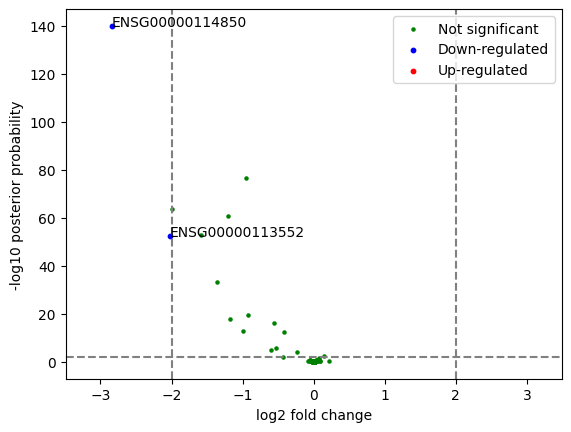

In [54]:
volcano(gasperini_perturbo)

## IGV

In [131]:
coordinate_dict = {}

In [132]:
for index, row in gasperini_perturbo["gene"].var.iterrows():
    if np.isnan(row["gene_start"]) or np.isnan(row["gene_end"]):
        continue
    coordinate_dict[index] = [row["gene_chr"], row["gene_start"], row["gene_end"]]

In [134]:
for index, row in gasperini_perturbo["guide"].var.iterrows():
    if row["intended_target_name"] in coordinate_dict or row["intended_target_name"] == "non-targeting":
        continue
    coordinate_dict[row["intended_target_name"]] = [row["intended_target_chr"], row["intended_target_start"], row["intended_target_end"]]

In [136]:
from collections import defaultdict

In [137]:
bedpe = defaultdict(list)
bedgraph = defaultdict(list)

for index, row in gasperini_perturbo.uns["test_results"].iterrows():
    if row["intended_target_name"] == row["gene_id"]:
        #PROMOTER
        bedgraph["chr"].append(coordinate_dict[row["intended_target_name"]][0])
        bedgraph["start"].append(coordinate_dict[row["intended_target_name"]][1])
        bedgraph["end"].append(coordinate_dict[row["intended_target_name"]][2])
        bedgraph["posterior_probability"].append(row["posterior_probability"])
        bedgraph["log2_fc"].append(row["log2_fc"])
    else:
        bedpe["chr1"].append(coordinate_dict[row["intended_target_name"]][0])
        bedpe["start1"].append(coordinate_dict[row["intended_target_name"]][1])
        bedpe["end1"].append(coordinate_dict[row["intended_target_name"]][2])

        bedpe["chr2"].append(coordinate_dict[row["gene_id"]][0])
        bedpe["start2"].append(coordinate_dict[row["gene_id"]][1])
        bedpe["end2"].append(coordinate_dict[row["gene_id"]][2])
        
        bedpe["posterior_probability"].append(row["posterior_probability"])
        bedpe["log2_fc"].append(row["log2_fc"])

In [138]:
bedpe_df = pd.DataFrame(bedpe)
bedgraph_df = pd.DataFrame(bedgraph)

In [140]:
bedpe_df

,chr1,start1,end1,chr2,start2,end2,posterior_probability,log2_fc
0,chr8,23366136.0,23366564.0,chr8,23386318.0,23386319.0,3.642015e-20,-0.923445
1,chr9,135879214.0,135879689.0,chr9,135820938.0,135820939.0,1.285547e-18,-1.170653
2,chr9,75758860.0,75759012.0,chr9,75766673.0,75766674.0,1.843007e-13,-1.000979
3,chr9,130624341.0,130624862.0,chr9,130635822.0,130635823.0,1.974124e-06,-0.525158
4,chr9,100723075.0,100723327.0,chr9,100745643.0,100745644.0,7.365440e-05,-0.228326
...,...,...,...,...,...,...,...,...
95,chr9,130624341.0,130624862.0,chr9,136223360.0,136223361.0,1.492934e-01,0.081736
96,chr9,130624341.0,130624862.0,chr9,131445934.0,131445935.0,1.240282e-01,0.049263
97,chr8,23366136.0,23366564.0,chr8,22462145.0,22462146.0,9.867019e-02,0.051342
98,chr9,130624341.0,130624862.0,chr9,131037658.0,131037659.0,2.470516e-02,0.078867


In [141]:
bedgraph_df

,chr,start,end,posterior_probability,log2_fc
0,chr3,156271913.0,156271914.0,1.173906e-140,-2.837359
1,chr12,76478445.0,76478446.0,2.978012e-77,-0.946061
2,chr17,55927404.0,55927405.0,2.515201e-64,-1.993496
3,chr4,56262124.0,56262125.0,1.988484e-61,-1.203412
4,chr1,35324645.0,35324646.0,1.062056e-53,-1.579744
5,chr5,141392358.0,141392359.0,3.524085e-53,-2.025771
6,chr6,53213723.0,53213724.0,6.176088e-34,-1.353762
7,chr1,156722239.0,156722240.0,5.745756e-17,-0.558912
8,chr7,12726481.0,12726482.0,5.312701e-13,-0.411777
9,chr3,195808960.0,195808961.0,7.058141e-06,-0.593732
